Row
    [0] Column(css_classes=['bordered-column'], sizing_mode='stretch_height')
        [0] Markdown(str, sizing_mode='stretch_width')
        [1] Markdown(str, min_height=100, sizing_mode='stretch_width')
        [2] PNG(str, sizing_mode='stretch_both')
        [3] Column(min_height=150, sizing_mode='stretch_height')
            [0] Markdown(str)
            [1] IntSlider(end=2030, name='Year', start=2026, value=2026)
            [2] DiscreteSlider(formatter='%d', name='MW Factor', options=[1, 10, 20, 30, ...], value=1)
    [1] Column
        [0] ParamFunction(function, _pane=GridBox, defer_load=False)
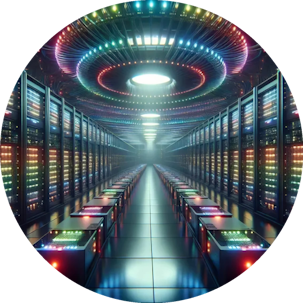

In [8]:
import pandas as pd
import panel as pn
import hvplot.pandas
import holoviews as hv
from io import StringIO
from holoviews import opts
hv.extension('bokeh')
pn.extension()
    
# Loading CSV file
df = pd.read_csv('data.csv', sep=';')
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Slider & button
year_slider = pn.widgets.IntSlider(name='Year', start=int(df['year'].min()), end=int(df['year'].max()), step=1, value=2026)
mw_values = [1] + list(range(10, 301, 10))
mw_slider = pn.widgets.DiscreteSlider(name='MW Factor', options=mw_values, value=1)
download_button = pn.widgets.FileDownload(label="📥 Esporta CSV", button_type="success", filename="dati_scalati.csv")

# Reactive Function
def update_dashboard(year, mw):
    selected_row = df[df['year'] == year].iloc[0]
    selected_roi = selected_row['roi']

    # Scaled calculations
    btc_generated = selected_row['btc_per_mw'] * mw
    gross_rev = selected_row['gross_rev'] * mw
    energy_cost = selected_row['energy_cost'] * mw
    opex = selected_row['opex'] * mw
    capex_amort = selected_row['capex_amort'] * mw
    tot_costs = selected_row['tot_costs'] * mw
    capex_tot = selected_row['capex_tot'] * mw
    taxes = selected_row['taxes'] * mw
    net_profits = selected_row['net_profits'] * mw

    # format number
    def format_millions_thousands(value):
        if value >= 1_000_000:
            return f"{value / 1_000_000:.0f}M"
        elif value >= 1_000:
            return f"{value / 1_000:.0f}K"
        else:
            return str(value)

 
    card_style = {
        'background': 'linear-gradient(to right, #592EEF, #FAF9FF)',
        'padding': '15px',
        'margin': '10px',
        'border-radius': '8px',
        'box-shadow': '2px 2px 6px #ccc',
        'flex': '1',
        'min-width': '200px',
        'text-align': 'center',
        'font-size': '16px',
    }
    
    # Layout with FlexBox
    cards = pn.Column(
        pn.Row(
            pn.pane.Markdown(f"### Year\n**{year}**", styles=card_style),
            pn.pane.Markdown(f"### MW Factor\n**{mw} MW**", styles=card_style),
            pn.pane.Markdown(f"### BTC Generated\n**{format_millions_thousands(btc_generated)} BTC**", styles=card_style),
            #pn.pane.Markdown(f"### Opex\n**$ {format_millions_thousands(opex)}**", styles=card_style),
            margin=10,
            sizing_mode="stretch_width"
        ),
        pn.Row(
            pn.pane.Markdown(f"### Total Costs\n**$ {format_millions_thousands(tot_costs)}**", styles=card_style),
            pn.pane.Markdown(f"### Net Profits\n**$ {format_millions_thousands(net_profits)}**", styles=card_style),            
            pn.pane.Markdown(f"### ROI\n**{format_millions_thousands(selected_roi)} %**", styles=card_style),

            margin=10,
            sizing_mode="stretch_width"
        )
    )
    
    # Create a copy of the DataFrame and calculate the scaled columns
    df_scaled = df.copy()
    df_scaled['btc_generated'] = df_scaled['btc_per_mw'] * mw
    
    # Apply the MW multiplier to the columns
    cols_to_scale = [
        'gross_rev', 'energy_cost', 'opex', 'capex_amort',
        'tot_costs', 'capex_tot', 'taxes', 'net_profits'
    ]
    
    for col in cols_to_scale:
        df_scaled[col] *= mw
    
    # Select the columns to display in the desired order
    columns_to_show = [
        'year', 'btc_price', 'btc_generated', 'gross_rev', 'energy_cost',
        'opex', 'capex_amort', 'tot_costs', 'capex_tot',
        'taxes', 'net_profits', 'payback', 'roi'
    ]
    
    # Rename scaled columns (optional, for clarity)
    df_view = df_scaled[columns_to_show].rename(columns={
        'btc_generated': f'btc_generated (MW={mw})',
        'gross_rev': f'gross_rev (MW={mw})',
        'energy_cost': f'energy_cost (MW={mw})',
        'opex': f'opex (MW={mw})',
        'capex_amort': f'capex_amort (MW={mw})',
        'tot_costs': f'tot_costs (MW={mw})',
        'capex_tot': f'capex_tot (MW={mw})',
        'taxes': f'taxes (MW={mw})',
        'net_profits': f'net_profits (MW={mw})',
    })
 
    df_plot_for_year = (
    df_scaled[df_scaled['year'] >= year]
    )

     # Create DataFrame across all MWs
    mw_range = list(range(1, mw + 1, 10))
    df_list = []
    for mw_i in mw_range:
        df_temp = df[df['year'] == year].copy()
        df_temp['mw_potenza'] = mw_i
        df_temp['btc_generated'] = df_temp['btc_per_mw'] * mw_i

        # Scala le colonne economiche
        for col in [
            'gross_rev', 'energy_cost', 'opex', 'capex_amort',
            'tot_costs', 'capex_tot', 'taxes', 'net_profits'
        ]:
            df_temp[col] *= mw_i

        df_list.append(df_temp)

    # Concatenate all MW
    df_plot_for_MW = pd.concat(df_list, ignore_index=True)
    df_plot_for_MW = df_plot_for_MW.sort_values('mw_potenza')
    df_plot_for_MW = df_plot_for_MW.reset_index(drop=True)

    # Graphics
    df_long = df_plot_for_year.melt(
        id_vars='year', 
        value_vars=['tot_costs', 'net_profits'], 
        var_name='metric', 
        value_name='value'
    )

    df_long['metric'] = pd.Categorical(df_long['metric'],
                                       categories=['tot_costs',
                                                   'net_profits'
                                                  ],
                                           ordered=True
                                      )
    
    plot_year = df_long.hvplot.bar(
        x='year', 
        y='value', 
        by='metric',  # questo fa il grouping / raggruppamento
        color=['#ff06da', '#71ff06'],
        bar_width=0.7,
        title=f"Net Profits ($) over Total Costs at year {year}"
    ).opts(
        height=400,
        xlim=(2026, 2030),
        xlabel='Year',
        ylabel='USD',
        show_legend=True,
        tools=['hover']
    )
  
    plot_powerMW = df_plot_for_MW.hvplot(
        x='mw_potenza', 
        y=['gross_rev','net_profits', 'taxes', 'tot_costs'], 
        kind='scatter', 
        size = 20,
        color=['#ff7506', '#2ca02c', '#F50105', '#B201F5'], 
        title=f"Various Metrics over power ({mw}MW)"
    ).opts(
        height=400,  
        xlim=(1, mw), 
        xlabel='Power', 
        ylabel='USD',
        show_legend = True, 
        tools=['hover']
    )
     # Stile CSS plot    
    cards_plot = pn.Column(
        pn.Row(
            plot_year,
            plot_powerMW,
            margin=10,
            sizing_mode="stretch_width"
        )
    )
   
    # Export in CSV file
    def csv_callback():
        sio = StringIO()
        df_scaled.to_csv(sio, index=False, sep=';')
        sio.seek(0)
        return sio

    download_button.callback = csv_callback


    numeric_cols = df_view.select_dtypes(include=['number']).columns
    styled_df_view = df_view.style.format({col: '{:,.2f}' for col in numeric_cols})
    
    # Style CSS dataframe    
    card_data_frame = pn.Column(
        pn.Row(
            pn.pane.Markdown("### Data Frame (Scaled per MW)"),
            margin=2,
            sizing_mode="stretch_width"
        ),
        pn.Row(
            pn.pane.DataFrame(
                styled_df_view,
                sizing_mode="stretch_both", 
                min_height=160
            ),
            margin=2,
            sizing_mode="stretch_both"
        ),
        pn.Row(
            download_button,
            margin=10,
            sizing_mode="stretch_width"
        ),
        sizing_mode="stretch_height"
    )

    # CSS style to add a border to each line
    row_style = """
        .bordered-row {
            border: 0.5px solid #ddd; /* Bordo grigio chiaro */
            padding: 5px; /* Spazio interno */
            margin-bottom: 7px; /* Spazio sotto ogni riga */
            border-radius: 4px; /* Bordi arrotondati */
            background-color: #f9f9f9; /* Colore di sfondo leggero */
        }
    """
    # CSS style to add a border to each column
    column_style = """
    .bordered-column {
        border: 0.5px solid #ddd;
        padding: 5px;
        margin-right: 10px; /* Qui è dove imposti il margine destro a 10px */
        border-radius: 4px;
        background-color: #f9f9f9;
    }
    """
    # Load CSS style
    pn.extension(raw_css=[row_style]) 
    pn.extension(raw_css=[column_style]) 

    layout = pn.GridBox(
        pn.Row(cards, css_classes=['bordered-row']),
        pn.Row(cards_plot, css_classes=['bordered-row']),
        pn.Row(card_data_frame, css_classes=['bordered-row']),
        ncols=1
    )

    return layout

dashboard_dynamic = pn.bind(update_dashboard, year=year_slider, mw=mw_slider)

# Final responsive layout
# Final interface
# Responsive layout with binding
# Create responsive function

dashboard = pn.Row(
    pn.Column(pn.pane.Markdown("# **Hydro Data Mining Scalable Simulation Model**", sizing_mode="stretch_width"),
              pn.pane.Markdown("#### **In the near future, Hydro Data Mining will become a cornerstone of the sustainable digital economy. By combining the energy efficiency of hydropower with the growing demand for computational power in mining and high-performance computing, the sector represents a strategic shift.**", sizing_mode="stretch_width", min_height=100),
              pn.pane.PNG('image.png', sizing_mode = 'stretch_both'),
              pn.Column(
                        pn.pane.Markdown("## Settings"),
                        year_slider,
                        mw_slider,
                        #sizing_mode='fixed',
                        min_height=150,
                        sizing_mode="stretch_height",
              ),
              sizing_mode="stretch_height",
              css_classes=['bordered-column']),
    pn.Column(dashboard_dynamic)
)
dashboard.servable()
